# How To Score Public LB 1777 in MOA Comp
In MOA (Mechanisms of Action) competition, we are challenged to predict 206 targets. The metric is the average of log losses for each target. The metric log loss is very sensitive to mean of predictions. Therefore if we know the mean of each target in test, we can improve each target's log loss by scaling our predictions to have the same mean as the test dataset.

**Disclaimer: During the competition we can not obtain any info about private test and can not achieve the private LB score of 1592 appearing in this notebook.** (We can obtain public LB 1777 during the comp) The best models in this competition are still the teams at the top of the private leaderboard. Congratulations to the winners. The final leaderboard is [here][2]

We can acquire the public test target means by probing the public LB. The `submission.csv` file has 206 columns (one for each target) and thousands of rows (one for each sample to be predicted). If we submit `submission.csv` with all zeros and then put all ones in the one of the target columns, we can compute the number of positive targets for that column of test dataset. Since the competition has ended, our probes will also return info about the private test dataset too.

Let's do that, analyze the results, and then apply that knowledge to post process my teammate Intwzt @intwzt TabNet model from [here][1]


# Let's Probe the LB

[1]: https://www.kaggle.com/intwzt/inference-tabnet-1830
[2]: https://www.kaggle.com/c/lish-moa/leaderboard

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
PROBE_COLUMN = 0

sub = pd.read_csv('../input/lish-moa/sample_submission.csv')
print('Submission file has shape', sub.shape )
print('We will probe target',sub.columns[1+PROBE_COLUMN])

In [ ]:
sub.iloc[:,1:] = 0
sub.iloc[:,1+PROBE_COLUMN] = 1
sub.to_csv('submission_probe_%i.csv'%PROBE_COLUMN)
sub.head()

If we submit this `submission_probe_0.csv` file, we get LB score. The first value is private LB, the second is public LB.
  
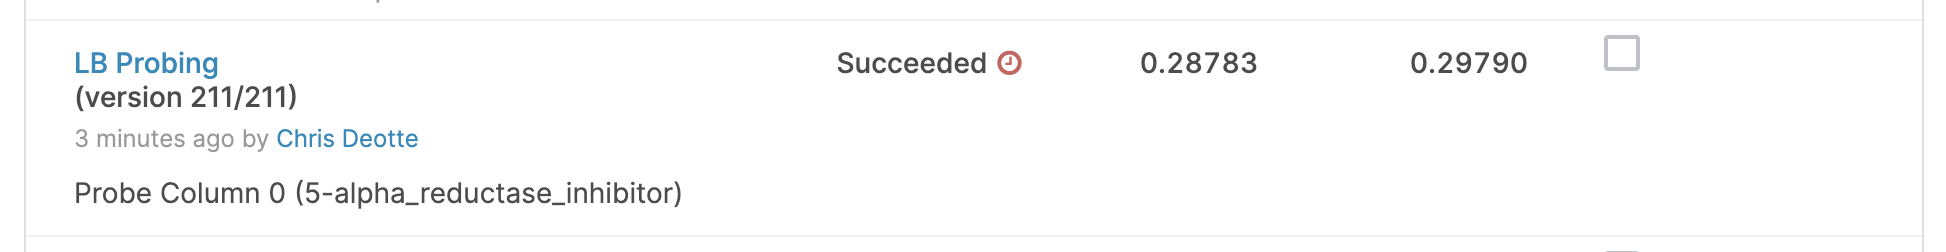
  
Next we need to submit all zeros for comparison. (We only do this once and will use with all 206 target column probes). 
  
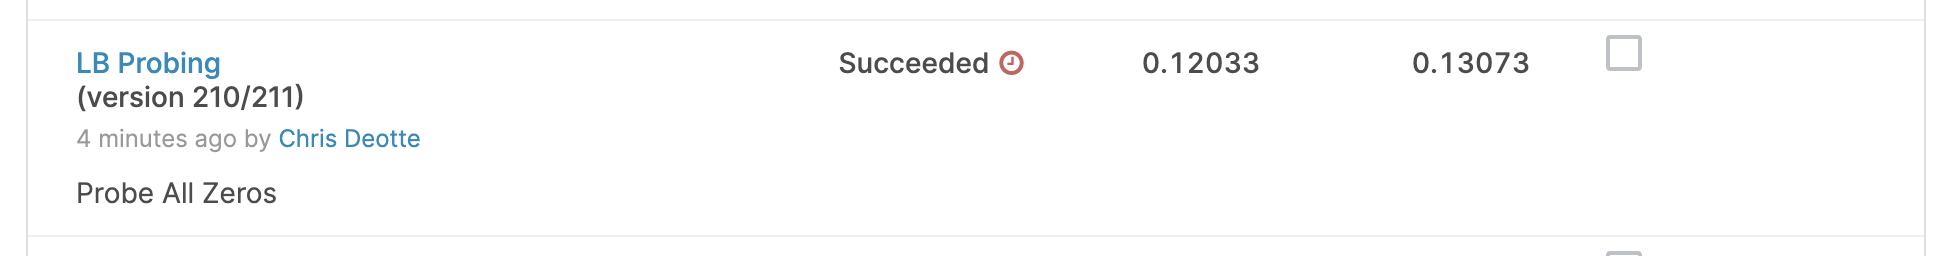

Now we do the math to compute how many targets are positive for public test column 5-alpha_reductase_inhibitor. 

If we had no wrong predictions, our LB would be zero. Each wrong prediction has individual log loss of `-log(1e-15)` because Kaggle clips prediction. And our public LB score is the average of 3982 rows times 206 columns equals 820292 predictions. Therefore each wrong prediction degrades our LB (which is the average of all individual prediction log losses) by `-log(1e-15) / 820292` equals `4e-5`.

The difference between submitting all zeros and all zeros with column 0 of ones is `0.29790 - 0.13073` equals `0.16717`, the difference of the two LB scores above. If we divide this quantity by `-log(1e-15) / 820292`, we compute how many new errors we get by switching to all ones.

In [ ]:
np.round( (0.29790 - 0.13073) / (-np.log(1e-15)/820292) )

Let's assume that a column of test dataset has `x` positive targets. When we predict all zeros we make `x` errors. When we predict all ones for that column we make `3982-x` errors since the column has 3982 rows. The difference between submitting all ones and all zeros for that column is `(3982-x) minus x = 3982 - 2x`.

From above, we know that `3982 - 2x = 3970`, therefore `2x = 12` and `x=6`. This means that the column `5-alpha_reductase_inhibitor` has 6 positive targets in public test dataset.

# Probe Results after 206 Submissions!
After making 206 submissions plus 1 submission of all zeros, we will know the number of targets for each target in public test dataset. Since the competition is over, we also can acquire the count for private test dataset too. I have done this and published the results in a Kaggle dataset [here][1] for everyone to analyze.

[1]: https://www.kaggle.com/cdeotte/moa-test-target-means

In [ ]:
test_counts = pd.read_csv('../input/moa-test-target-means/target_counts.csv')
test_counts.head()

# Explore
We can now compare the distribution of targets in train, public, and private. Note that the mean of the target is significant not the count only. For example 6 targets in train dataset has mean `6` divided by the length of train data which is `23814`. And 6 targets in public test has mean `6` divided by the length of public test which is `3982`.

In [ ]:
TRAIN_SZ = 23814
PUBLIC_SZ = 3982
PRIVATE_SZ = 3982*3

for k in range(9):
    a = 25*k; b = min(206,25*(k+1))
    df = test_counts.sort_values('train_ct').iloc[a:b].reset_index()
    plt.figure(figsize=(0.8*(b-a),5))
    plt.bar(df.index,df.train_ct/TRAIN_SZ,0.3,label='Train')
    plt.bar(df.index+0.3,df.public_ct/PUBLIC_SZ,0.3,label='Public')
    plt.bar(df.index+0.6,df.private_ct/PRIVATE_SZ,0.3,label='Private')
    plt.xticks(df.index,df.target,rotation=90, size=14)
    plt.yticks(size=14)
    plt.legend(prop={'size': 14})
    plt.title('Target Mean',size=16)
    plt.show()

# Test versus Train
In the following plots, we sort the targets by their frequency in train. The we plot with x axis from rarest in train to most common in train. The y axis is mean of target in train. The blue line below is train. The orange line is test data.

We can see that the distribution in private test is the same as train. We can see that the distribution in public test is different than train. Noteably, the rare targets occur more frequently in public test. This is caused by the fact that each drug is tested 6 times. Therefore if you add a new drug to public test, you add a minimum of 6 rows and all rows have the same target. Furthermore, public test was **not randomly** selected. Each rare MOA target was intentionally included. Ignoring the occasional single target, the smallest mean in public test is `6 / 3982 = 0.0015` and the smallest mean in train is `6 / 23814 = 0.00025`. This difference can be seen in the plots below.

Also the public test only has 3982 rows. If the rarest targets in public test had only 1 rows, there would be plenty of rows for other targets. However because we need to add the rare targets in as multiples of 6, we don't have many rows left. Thus we see that the often targets in public test are underrepresented.

In [ ]:
SMOOTH = 10
test_counts = test_counts.sort_values('train_ct').reset_index(drop=True)

plt.figure(figsize=(20,6))
plt.plot(test_counts.index,test_counts.train_ct.rolling(SMOOTH,min_periods=1).mean()/TRAIN_SZ,label='Train')
plt.plot(test_counts.index,test_counts.public_ct.rolling(SMOOTH,min_periods=1).mean()/PUBLIC_SZ,label='Public Test')
plt.title('Public Test versus Train',size=16)
plt.xlabel('Target',size=14)
plt.ylabel('Mean',size=14)
plt.legend()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(test_counts.index,test_counts.train_ct.rolling(SMOOTH,min_periods=1).mean()/TRAIN_SZ,label='Train')
plt.plot(test_counts.index,test_counts.private_ct.rolling(SMOOTH,min_periods=1).mean()/PRIVATE_SZ,label='Private Test')
plt.title('Private Test versus Train',size=16)
plt.xlabel('Target',size=14)
plt.ylabel('Mean',size=14)
plt.legend()
plt.show()

# Consequences of Public Test vs. Train
There are two main consequences of the differnce between public test and train.
* We can increase our public LB score by post processing our predictions. We can scale the rare target predictions so that they have 6 times the mean than train. We can scale the often occurring target predictions so that they have 0.70 times the mean than train.
* The second conequence is a CV LB gap explained below

# CV LB Gap
During the competition we observed a CV LB gap with public test score. But we did not observe a CV LB gap with private test score. Why was this?

This was caused by the difference of means displayed above. For the 60 rarest targets our models couldn't recognize the MOA targets from such little training data. Therefore our models would just predict a constant value for test predictions. 

In the train dataset, these 60 rarest targets had 6 postive targets out of 23814 for a mean of 0.00025. When you predict an entire column of 0.00025 for these drugs you get log loss `0.00234` which is very low. In public test dataset those same rare targets have 6 positive targets out of 3982 for a mean of 0.0015. When you predict an entire column of 0.0015 for these same drugs you get log loss `0.01132`. This is not as good.

For these 60 targets, each column's log loss is `0.01132 - 0.00234 = 0.00898` worse. When you compute LB by taking the average of all 206 columns this worsens the score by `0.00898 * 60 / 206 = 0.00262`. This is the CV LB gap that we observed using my double stratified CV discussed [here][1]. All the math is show below.

[1]: https://www.kaggle.com/c/lish-moa/discussion/195195

In [ ]:
from sklearn.metrics import log_loss
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

In [ ]:
# GET AN EXAMPLE OF RARE DRUG WITH 6 COUNTS
# THIS EXAMPLE HAS TARGET MEAN 0.00025
test_counts.loc[test_counts.train_ct==6].target.iloc[0]

In [ ]:
log_loss( train_targets['diuretic'], np.ones(23814)*6/23814)

In [ ]:
# GET AN EXAMPLE OF RARE DRUG WITH 36 COUNTS
# THIS EXAMPLE HAS TARGET MEAN 0.0015
test_counts.loc[test_counts.train_ct==36].target.iloc[0]

In [ ]:
log_loss( train_targets['casein_kinase_inhibitor'], np.ones(23814)*36/23814)

In [ ]:
# COMPUTE THE CV LB GAP
(0.01132 - 0.00234) * 60 / 206

# TabNet LB 1830
Working with teammates Intwzt @intwzt, Mizanur @mizanurr, Phi @ajinomoto132, Reza @vaghefi has been fun and rewarding. I learned so much about building tabular data deep learning models from them. Thank you team! I am in awe of their ability to build powerful models. Each team member focused on developing a different model. The list of models is published [here][1].

Intwzt @intwzt made an amazing TabNet which scored public LB 1830. The notebook is [here][2]. Notice all the amazing feature engineering!
* Autoencoder embeddings
* PCA
* Fast ICA
* FactorAnalysis
* FeatureAgglomeration
* Stat features
* Variance threshold
* Quantile transformer

We will now load the trained model from that notebook and add post processing.

Please also check out Phi @ajinomoto132 amazing EffNet model [here][3] which achieves LB 1840 when using 4 seeds. Our denoising autoencoder model is posted [here][4]. Our MX10 transfer learning model [here][5]. Please upvote their notebooks. Thank you!

[1]: https://www.kaggle.com/c/lish-moa/discussion/200614
[2]: https://www.kaggle.com/intwzt/inference-tabnet-1830
[3]: https://www.kaggle.com/ajinomoto132/efficientnet-swish-augmentation-training
[4]: https://www.kaggle.com/c/lish-moa/discussion/200680
[5]: https://www.kaggle.com/intwzt/updated-inference-final-mx10-transfer

# Post Process LB 1777
 
Using the data collected from LB probing, we will scale all the target predictions from our single model TabNet that achieves public LB 1830 and private LB 1622. The result achieves public LB 1777 and private LB 1592! 

Note that we would not be able to score private LB 1592 during the competition because we could not probe the private test means (during the comp). But we could have scored public 1777 during the competition (using 208 submissions).

In [ ]:
# RUN INFERENCE FOR SAVE TABNET MODEL
! python -W ignore ../input/finalmoascripts/inference-tabnet-1830.py

# LOAD RESULT
sub = pd.read_csv('submission_tabnet_01830.csv')
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

In [ ]:
# PLOT PREDICTIONS
x = sub.loc[test.cp_type=='trt_cp',sub.columns[1:]].values
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.hist( x[x<0.01], bins=100)
plt.subplot(1,2,2)
plt.hist( x[x>0.9], bins=100)
plt.show()

In [ ]:
# CONVERT PROBABILITIES TO ODDS, APPLY MULTIPLIER, CONVERT BACK TO PROBABILITIES
def scale(x,k):
    x = x.copy()
    idx = np.where(x!=1)[0]
    y = k * x[idx] / (1-x[idx])
    x[idx] =  y/(1+y)
    return x

In [ ]:
public = pd.read_csv('../input/moa-test-target-means/sample_public_submission.csv').sig_id.values
SZ = 3982; SZ2 = 3982*3

for c in test_counts.target.values:
    
    m2 = sub.loc[sub.sig_id.isin(public),c].mean()
    m3 = sub.loc[~sub.sig_id.isin(public),c].mean()
    m = test_counts.loc[test_counts.target==c,'public_ct'].values[0]/SZ /m2
    sub.loc[sub.sig_id.isin(public),c] = scale(sub.loc[sub.sig_id.isin(public),c].values,m)
    
    if len(sub)>len(public):
        
        m = test_counts.loc[test_counts.target==c,'private_ct'].values[0]/SZ2 /m3
        sub.loc[~sub.sig_id.isin(public),c] = scale(sub.loc[~sub.sig_id.isin(public),c].values,m)
                    
print('Updated',len(test_counts),'targets')

In [ ]:
# SAVE SUBMISSION FILE
s = sub.loc[(test.cp_type=='ctl_vehicle').values].mean().sum()
print('Control rows in submission have mean = %i'%s)

sub.to_csv('submission.csv',index=False)
sub.head()